# 16. Screen Coordinates

Attempt to train a model using a heatmap of the screen coordinates in the session.

In [1]:
import gc
import logging
from typing import Tuple

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from keras import callbacks

import matplotlib.pyplot as plt

2023-03-03 11:43:51.181054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 11:43:51.751345: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-03 11:43:51.751387: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-03 11:43:51.751393: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

## Load Source Data

In [3]:
# load the source training set
df_source = pd.read_csv('data/train.csv.gz', compression='gzip', index_col=1)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head(3))

(13174211, 19)


,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
index,,,,,,,,,,,,,,,,,,,
0,20090312431273200,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [4]:
# load the source training labels
df_source_labels = pd.read_csv('data/train_labels.csv')

print(df_source_labels.shape)
with pd.option_context('display.max_columns', None):
    display(df_source_labels.head(3))

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Functions

### Functions to prepare the data

In [5]:
def map_question_to_level_group(question_number):
    """
    Maps the question number to the level group.

    Parameters
    ----------
    question_number : int
        The question number.

    Returns
    -------
    str
        The level group.
    """
    if question_number in [1, 2, 3]:
        return '0-4'
    elif question_number in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        return '5-12'
    elif question_number in [14, 15, 16, 17, 18]:
        return '13-22'
    else:
        return None

def prepare_label_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the label dataset and add columns for the level group 
    and the question number.

    Parameters
    ----------
    data : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The prepared label dataset.
    """
    # add the columns to determine the level group
    df_labels = data \
        .rename(columns={'session_id': 'id'}) \
        .assign(session_id=lambda df: df['id'].str.split('_').str[0].astype(int)) \
        .assign(question_id=lambda df: df['id'].str.split('_').str[1]) \
        .assign(question_num=lambda df: df['question_id'].str[1:].astype(int)) \
        [['session_id', 'question_num', 'correct']]
    
    # add the level group column
    df_labels['level_group'] = df_labels['question_num'].apply(map_question_to_level_group) 
        
    return df_labels

In [6]:
def prepare_main_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the main dataset by removing duplicates and removing 
    columns that are not needed.

    Parameters
    ----------
    data : pd.DataFrame
        The main dataset.

    Returns
    -------
    pd.DataFrame
        The prepared main dataset.
    """
    empty_columns = ['fullscreen', 'hq', 'music', 'page', 'hover_duration']

    df_main = data \
        .drop_duplicates() \
        .reset_index(drop=True) \
        .drop(empty_columns, axis=1) \
        .drop('text', axis=1)

    return df_main

## Functions for Feature Engineering

In [7]:
def get_session_screen_coor(data: pd.DataFrame, session_id: int):
    # get the session data
    session_data = df_source[df_source['session_id'] == session_id]
    session_data = session_data[['screen_coor_x', 'screen_coor_y']]
    session_data = session_data.dropna()

    # get the screen coordinates
    screen_coor_x = session_data['screen_coor_x'].values
    screen_coor_y = session_data['screen_coor_y'].values
    
    return screen_coor_x, screen_coor_y

(50, 50)


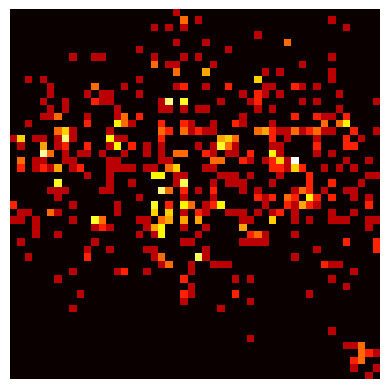

In [8]:
def create_heatmap(screen_coor_x, screen_coor_y):
    # Create the 2D histogram
    heatmap, xedges, yedges = np.histogram2d(screen_coor_y, screen_coor_x, bins=50)

    # Apply logarithmic transformation
    heatmap = np.log(heatmap + 1)

    return heatmap

# test the heatmap function
session_1_screen_coor_x, session_1_screen_coor_y =  \
    get_session_screen_coor(df_source, 20090312431273200)

session_1_heatmap = create_heatmap(session_1_screen_coor_x, session_1_screen_coor_y)
print(session_1_heatmap.shape)

plt.imshow(session_1_heatmap, cmap='hot', origin='lower')
plt.axis('off')
plt.show()

In [9]:
# # reshape for convolutional neural network 
# a = session_1_heatmap.reshape((session_1_heatmap.shape[0], session_1_heatmap.shape[1], 1))

# # try expand
# b = np.expand_dims(session_1_heatmap, axis=-1)

# np.array_equal(a, b)

### Functions to create datasets

In [10]:
def create_heatmap_vector_array(session_data: pd.DataFrame, 
                        level_group: int) -> np.array:
    """
    Creates a vector array for a specific session and question number.
    """
    # get the data for the session and level group
    df_session = session_data.query('level_group == @level_group')

    # get the data to create a heatmap
    heatmap_data = df_session[['screen_coor_x', 'screen_coor_y']].dropna()
    screen_coor_x = heatmap_data['screen_coor_x'].values
    screen_coor_y = heatmap_data['screen_coor_y'].values

    # create the heatmap
    heatmap = create_heatmap(screen_coor_x, screen_coor_y)

    # reshape the heatmap for the convolutional neural network
    vector_array = heatmap.reshape((heatmap.shape[0], heatmap.shape[1], 1))

    return vector_array

# test the vector array function
df_test = df_source[df_source['session_id'] == 21040510125933256]
test_vector_array_1 = create_heatmap_vector_array(df_source, '0-4')
test_vector_array_2 = create_heatmap_vector_array(df_source, '5-12')
test_vector_array_3 = create_heatmap_vector_array(df_source, '13-22')

print(test_vector_array_1.shape)
print(test_vector_array_2.shape)
print(test_vector_array_3.shape)

(50, 50, 1)
(50, 50, 1)
(50, 50, 1)


In [11]:
# df_source = prepare_main_dataset(df_source)
# df_source_labels = prepare_label_dataset(df_source_labels)

In [12]:
def create_dataset(X: pd.DataFrame,
                   y: pd.DataFrame,
                   session_list: list) -> Tuple[np.array, np.array, np.array]:
    """
    Creates a dataset for a specific set of sessions and question numbers.

    Parameters
    ----------
    X : pd.DataFrame
        The main dataset.

    y : pd.DataFrame
        The label dataset.

    session_ids : list
        The list of session ids.

    Returns
    -------
    Tuple[np.array, np.array]
        The features vector, image vector, and the labels.
    """
    X_image = []
    X_features = []
    y_dataset = []

    for session_id in tqdm(session_list):
        # get the session labels
        df_session_labels = y.query('session_id == @session_id')
        df_session = X.query('session_id == @session_id')

        # create the level group heatmaps
        vector_arrays = {
            '0-4': create_heatmap_vector_array(df_session, '0-4'),
            '5-12': create_heatmap_vector_array(df_session, '5-12'),
            '13-22': create_heatmap_vector_array(df_session, '13-22'),
        }
        # iterate over all the questions answered in the session
        for _, row in df_session_labels.iterrows():
            question_number = row['question_num']
            correct = row['correct']
            level_group = map_question_to_level_group(question_number)

            # append the output features
            X_features.append(row['question_num'])

            # append the output image
            X_image.append(vector_arrays[level_group])

            # add the label to the dataset
            y_dataset.append(correct)

    X_out_features = np.array(X_features, dtype=np.float64)
    X_out_image = np.array(X_image, dtype=np.float64)
    y_out = np.array(y_dataset)

    return X_out_features, X_out_image, y_out

# # test the function
# session_list = [20090312431273200, 21040510125933256, 21040510125933256]
# X_test_features, X_test_image, y_test = create_dataset(df_source, df_source_labels, session_list)

# print(X_test_features.shape)
# print(X_test_image.shape)
# print(y_test.shape)

In [13]:
def select_sessions(
        y: pd.DataFrame,
        sample_size: int,
        random_state: int=1337) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Selects a sample of sessions from the dataset.

    Parameters
    ----------
    y : pd.DataFrame
        The label dataset.
    sample_size : int
        The number of sessions to select.
    random_state : int
        The random state to use.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        The selected session ids, the main dataset and the label dataset.
    """
    # select all the unique session ids
    all_session_ids = y['session_id'].unique()

    # create a sample for testing
    session_ids = np.random.choice(all_session_ids, size=sample_size, replace=False)

    # split the dataset into train, validation and test sets
    train, test = train_test_split(session_ids, test_size=0.3)
    test, val = train_test_split(test, test_size=0.5)

    # print the number of sessions in each set
    print(f'Train: {len(train)}')
    print(f'Validation: {len(val)}')
    print(f'Test: {len(test)}')

    return train, val, test

### Functions for Model Training

In [14]:
def plot_loss(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

In [15]:
def plot_accuracy(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['accuracy'])

    if ('val_accuracy' in history.history):
        plt.plot(epochs, history.history['val_accuracy'])
        plt.legend(['Training acc', 'Validation acc'], loc='upper left')
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

In [16]:
def test_model(
        model,
        history: callbacks.History,
        X_test: np.ndarray,
        y_test: np.ndarray) -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    
    plot_loss(history)
    plot_accuracy(history)

    y_test_score = model.predict(X_test)
    threshold, _, _ = optimize_f1(y_test, y_test_score)

    print(classification_report(y_test, y_test_score > threshold))
    print(f'Optimized threshold for best F1: {threshold:.2f}')

    gc.collect()

    return threshold

In [17]:
def optimize_f1(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall

## Pre-process Data

### Pre-defined Values

### Perform Pre-Processing

In [18]:
# prepare the main dataset
df_source = prepare_main_dataset(df_source)

with pd.option_context('display.max_columns', None):
    print(df_source.shape)
    display(df_source.head(3))  

(13173445, 13)


,session_id,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1323,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,831,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [19]:
# prepare the label dataset
df_source_labels = prepare_label_dataset(df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_source_labels.sample(n=3, random_state=51))

,session_id,question_num,correct,level_group
21476,22010116250792520,2,1,0-4
84068,21000111433937450,8,1,5-12
171219,21040510125933256,15,0,13-22


In [20]:
gc.collect()

50

## Parameters

In [21]:
epochs = 20

loss = 'binary_crossentropy'
metrics = ['accuracy']

In [25]:
random_state = 51
#sample_size = df_source_labels['session_id'].nunique()
sample_size = 1000
batch_size = 64

## Data Selection

In [26]:
train, val, test = select_sessions(
    y=df_source_labels,
    sample_size=sample_size,
    random_state=random_state)

Train: 700
Validation: 150
Test: 150


## Create Datasets

In [27]:
# create the training dataset
X_train_features, X_train_image, y_train = create_dataset(
    X=df_source, y=df_source_labels, session_list=train)
gc.collect()

  0%|          | 0/700 [00:00<?, ?it/s]

779

In [28]:
# create the validation dataset
X_val_features, X_val_image, y_val = create_dataset(
    X=df_source, y=df_source_labels, session_list=val)
gc.collect()

  0%|          | 0/150 [00:00<?, ?it/s]

323

In [30]:
# create the test dataset
X_test_features, X_test_image, y_test = create_dataset(
    X=df_source, y=df_source_labels, session_list=test)
gc.collect()

  0%|          | 0/150 [00:00<?, ?it/s]

1172